In [18]:
import pandas as pd
import geopandas as gpd
# Import necessary geometric objects from shapely module
from shapely.geometry import Point, LineString, Polygon
import geopy
from geopy.geocoders import Nominatim
import skmob
import fiona

In [3]:
# Create a Polygon from the coordinates
poly = Polygon([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])

### Geographic Partionining
* We have a few options in partionining mobile data spatially
    * __Option 1__: Call a free geocoding API (i.e. Nominatim) to get the relevant OpenStreetMap information. From here we can find the bounding box coordinates of a particular POI
    * __Option 2__: Partition by federal and/or state designations, i.e. census tracts, zip codes, etc.

#### Geocoding Example

In [4]:
locator = Nominatim(user_agent="Untitled-1")

In [23]:
location = locator.geocode("Allerton Park & Retreat Center")
location.raw

{'place_id': 123369969,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 74924556,
 'boundingbox': ['39.9816336', '40.0139883', '-88.6741759', '-88.6273892'],
 'lat': '39.997755350000006',
 'lon': '-88.64642250857688',
 'display_name': 'Robert Allerton Park, Monticello, Piatt County, Illinois, 61856, United States',
 'class': 'leisure',
 'type': 'park',
 'importance': 0.521409003314806}

In [6]:
#bbox = list()
#[bbox.append(float(i)) for i in location.raw['boundingbox']]
#bbox

In [7]:
#from shapely.geometry import box
#miny, maxy, minx, maxx = bbox
#poly = box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
#poly

#### Census Tract Example

In [8]:
OK_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_40_tract_500k.zip"
OK_tracts = gpd.read_file(OK_url)
OK_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,40,007,951600,1400000US40007951600,40007951600,9516,Census Tract 9516,OK,Beaver County,Oklahoma,CT,1971018179,6122262,"POLYGON ((-100.95421 36.71703, -100.95421 36.7..."
1,40,139,950800,1400000US40139950800,40139950800,9508,Census Tract 9508,OK,Texas County,Oklahoma,CT,5124635,0,"POLYGON ((-101.49220 36.68950, -101.48157 36.6..."
2,40,047,001100,1400000US40047001100,40047001100,11,Census Tract 11,OK,Garfield County,Oklahoma,CT,972877962,1905317,"POLYGON ((-98.10438 36.47031, -98.10437 36.477..."
3,40,131,050104,1400000US40131050104,40131050104,501.04,Census Tract 501.04,OK,Rogers County,Oklahoma,CT,1956422,0,"POLYGON ((-95.63264 36.31094, -95.62823 36.311..."
4,40,101,000200,1400000US40101000200,40101000200,2,Census Tract 2,OK,Muskogee County,Oklahoma,CT,8409929,35504,"POLYGON ((-95.41162 35.78401, -95.40494 35.784..."


In [9]:
IL_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_17_tract_500k.zip"
IL_tracts = gpd.read_file(IL_url)
IL_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,17,143,000200,1400000US17143000200,17143000200,2,Census Tract 2,IL,Peoria County,Illinois,CT,971324,0,"POLYGON ((-89.64231 40.66903, -89.64230 40.670..."
1,17,143,003200,1400000US17143003200,17143003200,32,Census Tract 32,IL,Peoria County,Illinois,CT,3192142,0,"POLYGON ((-89.62153 40.77981, -89.62148 40.783..."
2,17,003,957900,1400000US17003957900,17003957900,9579,Census Tract 9579,IL,Alexander County,Illinois,CT,10197484,4353423,"POLYGON ((-89.19649 37.00498, -89.19298 37.006..."
3,17,073,030800,1400000US17073030800,17073030800,308,Census Tract 308,IL,Henry County,Illinois,CT,22273126,31720,"POLYGON ((-89.92486 41.24720, -89.92063 41.248..."
4,17,107,953100,1400000US17107953100,17107953100,9531,Census Tract 9531,IL,Logan County,Illinois,CT,13166640,375360,"POLYGON ((-89.41759 40.16712, -89.41683 40.172..."


#### Now let's read in our mobile data
* IL first

In [10]:
IL_data = pd.read_csv('IL_1000_April06-08.csv')
IL_gpd = gpd.GeoDataFrame(IL_data, crs='EPSG:4269', geometry=gpd.points_from_xy(IL_data['lon'], IL_data['lat']))
#aea_proj_str = '+proj=aea +lat_1=38.00 +lat_2=42.00 +lat_0=40.11 +lon_0=-88.228'
#IL_gpd = IL_gpd.to_crs(aea_proj_str)

In [11]:
# Exclude points outside of Illinois
IL_gpd_j = gpd.sjoin(IL_gpd, IL_tracts, how='inner', predicate='within')

In [12]:
print(IL_gpd.shape[0])
print(IL_gpd_j.shape[0])

235367
224500


#### Let's look at Tulsa

In [61]:
OK_data = pd.read_csv('OK_1000_May14-16.csv')
OK_gpd = gpd.GeoDataFrame(OK_data, crs='EPSG:4269', geometry=gpd.points_from_xy(OK_data['lon'], OK_data['lat']))
#aea_proj_str = '+proj=aea +lat_1=38.00 +lat_2=42.00 +lat_0=40.11 +lon_0=-88.228'
#IL_gpd = IL_gpd.to_crs(aea_proj_str)

# Exclude points outside of Oklahoma
OK_gpd_j = gpd.sjoin(OK_gpd, OK_tracts, how='inner', predicate='within')

# Create datetime column using timestamps
OK_gpd_j['datetime'] = pd.to_datetime(OK_gpd_j['timestamp'], unit='s')

# Create a date column
OK_gpd_j['date'] = OK_gpd_j['datetime'].dt.date

In [45]:
# Preprocess mobility data; separate by user_ID, filter out points with speed > 400 km/h, 
# and compress points within 200 m of each other in the same trajectory
tdf = skmob.TrajDataFrame(OK_gpd_j, latitude='lat', longitude='lon', datetime='datetime', user_id='uid')
f_tdf = skmob.preprocessing.filtering.filter(tdf, max_speed_kmh=400, include_loops=False)
fc_tdf = skmob.preprocessing.compression.compress(f_tdf, spatial_radius_km=0.2)

In [46]:
gdf_tulsa = gpd.GeoDataFrame(fc_tdf, crs='EPSG:4269', geometry=gpd.points_from_xy(fc_tdf['lng'], fc_tdf['lat']))

gdf_tulsa['datetime'] = pd.to_datetime(gdf_tulsa['datetime'], format='%Y-%m-%d %H:%M:%S')
gdf_tulsa['datetime'] = gdf_tulsa['datetime'].dt.strftime('%Y%m%d%H%M%S')

In [47]:
gdf_tulsa.shape

(96990, 27)

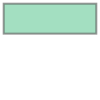

In [49]:
from shapely.geometry import box
# Define bounding box of damage site
minx, miny, maxx, maxy = [-95.526, 35.571, -95.254, 35.659]
poly = box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
poly

In [50]:
# Retrieve all mobile data points within the bounding box
damage_area_pts = gdf_tulsa.cx[minx:maxx, miny:maxy]

In [82]:
damage_area_pts['datetime'] = pd.to_datetime(damage_area_pts['datetime'], format='%Y%m%d%H%M%S')
# Groupby 'uid' and sort by 'datetime'
damage_area_pts = damage_area_pts.groupby('uid').apply(lambda x: x.sort_values('datetime'))

# Make date column a string
damage_area_pts['date'] = damage_area_pts['datetime'].dt.date.astype(str)

# Separate by date
damage_area_pre = damage_area_pts[damage_area_pts['date'] == '2020-05-14']
damage_area_dur = damage_area_pts[damage_area_pts['date'] == '2020-05-15']
damage_area_post = damage_area_pts[damage_area_pts['date'] == '2020-05-16']

C:\Users\stlp\AppData\Local\Temp\ipykernel_7856\1601473356.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  damage_area_pts = damage_area_pts.groupby('uid').apply(lambda x: x.sort_values('datetime'))


In [87]:
damage_area_dur.iloc[-1]

Unnamed: 0                                                 25912
timestamp                                             1589557252
uid            12b4779932a6b1d2dcf7cc8940032d77b7bcae40f9ebc4...
dtype                                                          1
lat                                                    35.633588
lng                                                   -95.459912
acc                                                           12
tz                                                        -18000
class                                                      OTHER
transform                                                   KEEP
timestamp2                                            1589539252
datetime                                     2020-05-15 15:40:52
geometry                            POINT (-95.459912 35.633588)
index_right                                                 1137
STATEFP                                                       40
COUNTYFP                 

In [88]:
from skmob.measures.individual import jump_lengths, radius_of_gyration, home_location

damage_area_pre_tdf = skmob.TrajDataFrame(damage_area_pre, latitude='lat', longitude='lng', datetime='datetime', user_id='uid')
damage_area_post_tdf = skmob.TrajDataFrame(damage_area_post, latitude='lat', longitude='lng', datetime='datetime', user_id='uid')

rg_df_pre = skmob.measures.individual.radius_of_gyration(damage_area_pre_tdf)
rg_df_post = skmob.measures.individual.radius_of_gyration(damage_area_post_tdf)

100%|██████████| 5/5 [00:00<00:00, 418.06it/s]


In [90]:
print(rg_df_pre)
print(rg_df_post)

                                                 uid  radius_of_gyration
0  037f0b170869db4be56a791c6c887e5b20f86bdba03421...            0.000000
1  1080fefe3fd3cc26c016b33c44ecd33fe5096d4148a23d...            3.054591
2  16432b557be8fd58fabe985ee9ffc996f642239763c720...            5.567875
3  19a20476c48970975cf2bf5ae755255a7013c20d25cfb9...            0.000000
                                                 uid  radius_of_gyration
0  05bd8133882bab54e9260df62c00a6f211c1e171cc1291...            3.026961
1  1080fefe3fd3cc26c016b33c44ecd33fe5096d4148a23d...            2.164827
2  1253bf323cfba0d5e7ff5b7500e52b59009438e53dd079...            3.028116
3  155d17e7b9e5bd1ab27f22411777be4503cf1fecf21928...            0.000000
4  16da7aba5119030149cc90b372f7d136a70bd7a0910f30...            0.495226
